In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/*.csv /content/data/

In [54]:
### --- Additional lib installs --- ###
!pip install catboost
!pip install xgboost

In [55]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### ------------- Packages for predictions --------- ###
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import mean_squared_error



In [56]:
def read_csv(path_to_file):
  return pd.read_csv(path_to_file)

# df_Delhi = read_csv('/content/data/City_Mumbai_wise_raw_data_1Hr_2019_2023.csv')
# df_Bengaluru = read_csv('/content/data/City_Bengaluru_wise_raw_data_1Hr_2019_2023.csv')
# df_Hyderabad = read_csv('/content/data/City_Hyderabad_wise_raw_data_1Hr_2019_2023.csv')
# df_Chennai = read_csv('/content/data/City_Chennai_wise_raw_data_1Hr_2019_2023.csv')
# df_Kolkata = read_csv('/content/data/City_Kolkata_wise_raw_data_1Hr_2019_2023.csv')
# df_Mumbai = read_csv('/content/data/City_Mumbai_wise_raw_data_1Hr_2019_2023.csv')
df_All_cities = read_csv('/content/data/City_All_wise_raw_data_1Hr_2019_2023.csv')



In [57]:
df_All_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   City                 262944 non-null  object 
 1   Timestamp            262944 non-null  object 
 2   PM2.5 (µg/m³)        262840 non-null  float64
 3   PM10 (µg/m³)         256602 non-null  float64
 4   NO (µg/m³)           262647 non-null  float64
 5   NO2 (µg/m³)          262532 non-null  float64
 6   NOx (ppb)            262853 non-null  float64
 7   NH3 (µg/m³)          258772 non-null  float64
 8   SO2 (µg/m³)          262736 non-null  float64
 9   CO (mg/m³)           262890 non-null  float64
 10  Ozone (µg/m³)        262846 non-null  float64
 11  Benzene (µg/m³)      262830 non-null  float64
 12  Toluene (µg/m³)      246592 non-null  float64
 13  Xylene (µg/m³)       141329 non-null  float64
 14  O Xylene (µg/m³)     64979 non-null   float64
 15  Eth-Benzene (µg/m

In [58]:
df_All_cities['Timestamp'] = pd.to_datetime(df_All_cities['Timestamp'])
df_All_cities.info()
df_All_cities = df_All_cities.sort_values(by=['City', 'Timestamp']).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   City                 262944 non-null  object        
 1   Timestamp            262944 non-null  datetime64[ns]
 2   PM2.5 (µg/m³)        262840 non-null  float64       
 3   PM10 (µg/m³)         256602 non-null  float64       
 4   NO (µg/m³)           262647 non-null  float64       
 5   NO2 (µg/m³)          262532 non-null  float64       
 6   NOx (ppb)            262853 non-null  float64       
 7   NH3 (µg/m³)          258772 non-null  float64       
 8   SO2 (µg/m³)          262736 non-null  float64       
 9   CO (mg/m³)           262890 non-null  float64       
 10  Ozone (µg/m³)        262846 non-null  float64       
 11  Benzene (µg/m³)      262830 non-null  float64       
 12  Toluene (µg/m³)      246592 non-null  float64       
 13  Xylene (µg/m³)

In [59]:
def missing_percentage(df):
  return (df.isnull().sum() / len(df)) * 100

missing_percentage_df = pd.DataFrame(missing_percentage(df_All_cities))
missing_percentage_df.reset_index(inplace=True)
missing_percentage_df.columns = ['Column Name', 'Missing Percentage']
missing_percentage_df

,Column Name,Missing Percentage
0,City,0.000000
1,Timestamp,0.000000
2,PM2.5 (µg/m³),0.039552
3,PM10 (µg/m³),2.411920
4,NO (µg/m³),0.112952
5,NO2 (µg/m³),0.156687
6,NOx (ppb),0.034608
7,NH3 (µg/m³),1.586650
8,SO2 (µg/m³),0.079104
9,CO (mg/m³),0.020537


In [60]:
threshold = 10

columns_to_keep = missing_percentage_df[missing_percentage_df['Missing Percentage'] < threshold]['Column Name'].tolist()
columns_to_drop = missing_percentage_df[missing_percentage_df['Missing Percentage'] >= threshold]['Column Name'].tolist()

print("Columns to keep:")
print(columns_to_keep)

print("\nColumns to drop:")
print(columns_to_drop)

df_All_cities = df_All_cities[columns_to_keep]

Columns to keep:
['City', 'Timestamp', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)', 'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'SR (W/mt2)', 'BP (mmHg)']

Columns to drop:
['Xylene (µg/m³)', 'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)', 'RF (mm)', 'VWS (m/s)']


In [61]:
missing_percentage_df = pd.DataFrame(missing_percentage(df_All_cities))
missing_percentage_df.reset_index(inplace=True)
missing_percentage_df.columns = ['Column Name', 'Missing Percentage']
missing_percentage_df

,Column Name,Missing Percentage
0,City,0.000000
1,Timestamp,0.000000
2,PM2.5 (µg/m³),0.039552
3,PM10 (µg/m³),2.411920
4,NO (µg/m³),0.112952
5,NO2 (µg/m³),0.156687
6,NOx (ppb),0.034608
7,NH3 (µg/m³),1.586650
8,SO2 (µg/m³),0.079104
9,CO (mg/m³),0.020537


In [62]:
# Interpolate missing values using linear interpolation for time series data
for column in df_All_cities.columns:
  if df_All_cities[column].dtype != 'object':  # Only interpolate numerical columns
    df_All_cities[column] = df_All_cities[column].interpolate(method='linear')

# Print some info about the new DataFrame
df_All_cities.info()
missing_percentage_df = pd.DataFrame(missing_percentage(df_All_cities))
missing_percentage_df.reset_index(inplace=True)
missing_percentage_df.columns = ['Column Name', 'Missing Percentage']
missing_percentage_df

<ipython-input-62-8c04ccdf3bc0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_All_cities[column] = df_All_cities[column].interpolate(method='linear')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   City             262944 non-null  object        
 1   Timestamp        262944 non-null  datetime64[ns]
 2   PM2.5 (µg/m³)    262944 non-null  float64       
 3   PM10 (µg/m³)     262944 non-null  float64       
 4   NO (µg/m³)       262944 non-null  float64       
 5   NO2 (µg/m³)      262944 non-null  float64       
 6   NOx (ppb)        262944 non-null  float64       
 7   NH3 (µg/m³)      262944 non-null  float64       
 8   SO2 (µg/m³)      262944 non-null  float64       
 9   CO (mg/m³)       262944 non-null  float64       
 10  Ozone (µg/m³)    262944 non-null  float64       
 11  Benzene (µg/m³)  262944 non-null  float64       
 12  Toluene (µg/m³)  262944 non-null  float64       
 13  AT (°C)          262944 non-null  float64       
 14  RH (%)           262

,Column Name,Missing Percentage
0,City,0.0
1,Timestamp,0.0
2,PM2.5 (µg/m³),0.0
3,PM10 (µg/m³),0.0
4,NO (µg/m³),0.0
5,NO2 (µg/m³),0.0
6,NOx (ppb),0.0
7,NH3 (µg/m³),0.0
8,SO2 (µg/m³),0.0
9,CO (mg/m³),0.0


In [63]:
# Vehicular pollution content = PM2.5 + PM10 + NO + NO2 + NOx + NH3 + CO

# Calculate Vehicular pollution content
df_All_cities['Vehicular_Pollution'] = df_All_cities['PM2.5 (µg/m³)'] + df_All_cities['PM10 (µg/m³)'] + df_All_cities['NO (µg/m³)'] + df_All_cities['NO2 (µg/m³)'] + df_All_cities['NOx (ppb)'] + df_All_cities['NH3 (µg/m³)'] + df_All_cities['CO (mg/m³)']
# Industrial pollution content = SO2 + Ozone + Benzene

# Calculate Industrial pollution content
df_All_cities['Industrial_Pollution'] = df_All_cities['SO2 (µg/m³)'] + df_All_cities['Ozone (µg/m³)'] + df_All_cities['Benzene (µg/m³)']
df_All_cities.info()
df_All_cities.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   City                  262944 non-null  object        
 1   Timestamp             262944 non-null  datetime64[ns]
 2   PM2.5 (µg/m³)         262944 non-null  float64       
 3   PM10 (µg/m³)          262944 non-null  float64       
 4   NO (µg/m³)            262944 non-null  float64       
 5   NO2 (µg/m³)           262944 non-null  float64       
 6   NOx (ppb)             262944 non-null  float64       
 7   NH3 (µg/m³)           262944 non-null  float64       
 8   SO2 (µg/m³)           262944 non-null  float64       
 9   CO (mg/m³)            262944 non-null  float64       
 10  Ozone (µg/m³)         262944 non-null  float64       
 11  Benzene (µg/m³)       262944 non-null  float64       
 12  Toluene (µg/m³)       262944 non-null  float64       
 13 

,City,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),...,Toluene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),TOT-RF (mm),SR (W/mt2),BP (mmHg),Vehicular_Pollution,Industrial_Pollution
0,Bengaluru,2019-01-01 00:00:00,65.57750,114.508571,8.978889,32.584,32.032222,18.456667,11.620000,0.787000,...,1.786667,19.913333,69.394286,1.314,96.868750,0.0,5.9325,842.352857,272.924849,65.090000
1,Bengaluru,2019-01-01 01:00:00,78.85750,113.858571,6.838889,28.406,26.895556,17.600000,9.965556,0.837000,...,1.516667,19.600000,75.091429,1.122,99.283750,0.0,5.9425,842.815714,273.293516,64.035556
2,Bengaluru,2019-01-01 02:00:00,72.04875,107.607143,5.527778,26.273,23.844444,17.388333,11.176667,0.771000,...,1.393333,19.183333,78.778571,1.244,97.250000,0.0,5.4925,843.092857,253.460448,75.822381
3,Bengaluru,2019-01-01 03:00:00,70.82750,97.677143,4.716667,22.411,20.822222,16.985000,11.398889,0.720000,...,1.120000,18.626667,82.374286,1.300,95.753750,0.0,5.7575,843.340000,234.159532,78.536032
4,Bengaluru,2019-01-01 04:00:00,70.23750,97.400000,4.823333,19.147,18.756667,16.846667,7.785556,0.631111,...,0.946667,18.325000,84.477143,1.312,94.514286,0.0,6.6875,844.182857,227.842278,78.238413


In [64]:

df_All_cities['PM2.5_24hr_avg'] = df_All_cities.groupby('City')['PM2.5 (µg/m³)'].rolling(window = 24, min_periods = 16).mean().values
df_All_cities['PM10_24hr_avg'] = df_All_cities.groupby('City')['PM10 (µg/m³)'].rolling(window = 24, min_periods = 16).mean().values
# df_All_cities['NO_24hr_avg'] = df_All_cities.groupby('City')['NO (µg/m³)'].rolling(window = 24, min_periods = 16).mean().values
df_All_cities['NO2_24hr_avg'] = df_All_cities.groupby('City')['NO2 (µg/m³)'].rolling(window = 24, min_periods = 16).mean().values
# df_All_cities['NOx_24hr_avg'] = df_All_cities.groupby('City')['NOx (ppb)'].rolling(window = 24, min_periods = 16).mean().values
df_All_cities['NH3_24hr_avg'] = df_All_cities.groupby('City')['NH3 (µg/m³)'].rolling(window = 24, min_periods = 16).mean().values
df_All_cities['CO_8hr_max'] = df_All_cities.groupby('City')['CO (mg/m³)'].rolling(window = 8, min_periods = 1).max().values
df_All_cities['SO2_24hr_avg'] = df_All_cities.groupby('City')['SO2 (µg/m³)'].rolling(window = 24, min_periods = 16).mean().values
df_All_cities['Ozone_8hr_max'] = df_All_cities.groupby('City')['Ozone (µg/m³)'].rolling(window = 8, min_periods = 1).max().values


df_All_cities.info()
# df_All_cities.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   City                  262944 non-null  object        
 1   Timestamp             262944 non-null  datetime64[ns]
 2   PM2.5 (µg/m³)         262944 non-null  float64       
 3   PM10 (µg/m³)          262944 non-null  float64       
 4   NO (µg/m³)            262944 non-null  float64       
 5   NO2 (µg/m³)           262944 non-null  float64       
 6   NOx (ppb)             262944 non-null  float64       
 7   NH3 (µg/m³)           262944 non-null  float64       
 8   SO2 (µg/m³)           262944 non-null  float64       
 9   CO (mg/m³)            262944 non-null  float64       
 10  Ozone (µg/m³)         262944 non-null  float64       
 11  Benzene (µg/m³)       262944 non-null  float64       
 12  Toluene (µg/m³)       262944 non-null  float64       
 13 

In [65]:
def PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df_All_cities['PM2.5_SubIndex'] = df_All_cities['PM2.5_24hr_avg'].apply(lambda x: PM25_subindex(x))


def PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df_All_cities['PM10_SubIndex'] = df_All_cities['PM10_24hr_avg'].apply(lambda x: PM10_subindex(x))


def SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

df_All_cities['SO2_SubIndex'] = df_All_cities['SO2_24hr_avg'].apply(lambda x: SO2_subindex(x))


def NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df_All_cities['NO2_SubIndex'] = df_All_cities['NO2_24hr_avg'].apply(lambda x: NO2_subindex(x))


def NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

df_All_cities['NH3_SubIndex'] = df_All_cities['NH3_24hr_avg'].apply(lambda x: NH3_subindex(x))


def CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

df_All_cities['CO_SubIndex'] = df_All_cities['CO_8hr_max'].apply(lambda x: CO_subindex(x))


def O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

df_All_cities['O3_SubIndex'] = df_All_cities['Ozone_8hr_max'].apply(lambda x: O3_subindex(x))


In [66]:
df_All_cities.info()
# df_All_cities.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   City                  262944 non-null  object        
 1   Timestamp             262944 non-null  datetime64[ns]
 2   PM2.5 (µg/m³)         262944 non-null  float64       
 3   PM10 (µg/m³)          262944 non-null  float64       
 4   NO (µg/m³)            262944 non-null  float64       
 5   NO2 (µg/m³)           262944 non-null  float64       
 6   NOx (ppb)             262944 non-null  float64       
 7   NH3 (µg/m³)           262944 non-null  float64       
 8   SO2 (µg/m³)           262944 non-null  float64       
 9   CO (mg/m³)            262944 non-null  float64       
 10  Ozone (µg/m³)         262944 non-null  float64       
 11  Benzene (µg/m³)       262944 non-null  float64       
 12  Toluene (µg/m³)       262944 non-null  float64       
 13 

In [67]:
df_All_cities['Checks'] = (df_All_cities['PM2.5_SubIndex'] > 0).astype(int) + \
                          (df_All_cities['PM10_SubIndex'] > 0).astype(int) + \
                          (df_All_cities['SO2_SubIndex'] > 0).astype(int) +  \
                          (df_All_cities['NO2_SubIndex'] > 0).astype(int) + \
                          (df_All_cities['NH3_SubIndex'] > 0).astype(int) + \
                          (df_All_cities['CO_SubIndex'] > 0).astype(int) + \
                          (df_All_cities['O3_SubIndex'] > 0).astype(int)

df_All_cities['AQI'] = round(df_All_cities[['PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'NO2_SubIndex',
                                 'NH3_SubIndex', 'CO_SubIndex', 'O3_SubIndex']].max(axis = 1))
df_All_cities.loc[df_All_cities['PM2.5_SubIndex'] + df_All_cities['PM10_SubIndex'] <= 0, 'AQI'] = np.NaN
df_All_cities.loc[df_All_cities.Checks < 3, 'AQI'] = np.NaN

In [68]:
def AQI_class(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df_All_cities["AQI_class"] = df_All_cities["AQI"].apply(lambda x: AQI_class(x))

In [69]:
df_All_cities_2019_2022 = df_All_cities[(df_All_cities['Timestamp'].dt.year >= 2019) & (df_All_cities['Timestamp'].dt.year <= 2022)]
df_All_cities_2023 = df_All_cities[df_All_cities['Timestamp'].dt.year == 2023]
df_All_cities_2019_2022.reset_index(drop=True, inplace=True)
df_All_cities_2023.reset_index(drop=True, inplace=True)

In [70]:
df_All_cities[df_All_cities['City'] == 'Delhi'].head(20)

,City,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),...,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI,AQI_class
87648,Delhi,2019-01-01 00:00:00,404.860811,635.825588,155.767222,75.565405,188.796389,62.597500,16.946452,3.955429,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87649,Delhi,2019-01-01 01:00:00,408.670000,617.085588,143.887714,71.750000,169.264118,63.128889,15.571613,3.422286,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87650,Delhi,2019-01-01 02:00:00,398.936216,592.965294,121.345294,67.724000,145.912424,55.737692,13.771379,3.214545,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87651,Delhi,2019-01-01 03:00:00,367.647568,538.715294,120.034444,62.672222,143.874857,55.827778,13.155484,2.733714,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87652,Delhi,2019-01-01 04:00:00,340.117027,506.155000,122.677895,56.890526,141.795135,55.942222,12.484516,2.243429,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87653,Delhi,2019-01-01 05:00:00,311.517838,467.005000,107.016842,54.221842,124.131351,53.087143,11.832903,1.933143,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87654,Delhi,2019-01-01 06:00:00,291.180811,438.669412,101.014211,53.411316,120.661622,54.021071,11.575806,2.094571,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87655,Delhi,2019-01-01 07:00:00,283.297027,438.540294,102.211842,55.998684,119.636487,54.629286,11.740000,2.092000,...,0.000000,0.000000,0.000000,0.000000,0.000000,124.442857,18.593243,2,NaN,NaN
87656,Delhi,2019-01-01 08:00:00,295.934595,475.732647,97.288947,71.167105,124.017297,57.875000,14.109355,2.110571,...,0.000000,0.000000,0.000000,0.000000,0.000000,117.778571,17.146000,2,NaN,NaN
87657,Delhi,2019-01-01 09:00:00,315.440811,513.020294,59.951579,85.008421,100.789460,61.346429,17.893871,1.849714,...,0.000000,0.000000,0.000000,0.000000,0.000000,115.181818,18.302162,2,NaN,NaN


In [71]:
df_All_cities.info()
df_All_cities_2023.info()
df_All_cities_2019_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   City                  262944 non-null  object        
 1   Timestamp             262944 non-null  datetime64[ns]
 2   PM2.5 (µg/m³)         262944 non-null  float64       
 3   PM10 (µg/m³)          262944 non-null  float64       
 4   NO (µg/m³)            262944 non-null  float64       
 5   NO2 (µg/m³)           262944 non-null  float64       
 6   NOx (ppb)             262944 non-null  float64       
 7   NH3 (µg/m³)           262944 non-null  float64       
 8   SO2 (µg/m³)           262944 non-null  float64       
 9   CO (mg/m³)            262944 non-null  float64       
 10  Ozone (µg/m³)         262944 non-null  float64       
 11  Benzene (µg/m³)       262944 non-null  float64       
 12  Toluene (µg/m³)       262944 non-null  float64       
 13 

---------------------------------------------------------------------------
---------------------------------------------------------------------------
**NOTE: All the above steps are common with the EDA python notebook.**

Below steps implement/train the different models and compare the accuracy amongst them to select the best/final model.

Models are trained using AQI data from the years 2019 to 2022.

Final model testing is perfomed using the 2023 year data (unseen data).

---------------------------------------------------------------------------
---------------------------------------------------------------------------

In [72]:
columns_for_prediction =  ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)', 'AQI', 'AQI_class']
validate_df = df_All_cities_2019_2022[columns_for_prediction]
test_df = df_All_cities_2023[columns_for_prediction]
test_df.AQI_class.value_counts()

,count
AQI_class,
Satisfactory,27321
Moderate,13212
Good,6024
Poor,2939
Very Poor,2481
Severe,583


In [73]:
test_df.AQI_class.value_counts()

,count
AQI_class,
Satisfactory,27321
Moderate,13212
Good,6024
Poor,2939
Very Poor,2481
Severe,583


In [74]:
validate_df = validate_df[['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'CO (mg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)', "AQI"]]
validate_df.isnull().sum()

,0
PM2.5 (µg/m³),0
PM10 (µg/m³),0
NO2 (µg/m³),0
CO (mg/m³),0
SO2 (µg/m³),0
Ozone (µg/m³),0
AQI,90


In [75]:
test_df = test_df[['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'CO (mg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)', "AQI"]]
test_df.isnull().sum()

,0
PM2.5 (µg/m³),0
PM10 (µg/m³),0
NO2 (µg/m³),0
CO (mg/m³),0
SO2 (µg/m³),0
Ozone (µg/m³),0
AQI,0


In [76]:
clean_df = validate_df.dropna()

In [77]:
clean_test_df = test_df.dropna()

<Axes: >

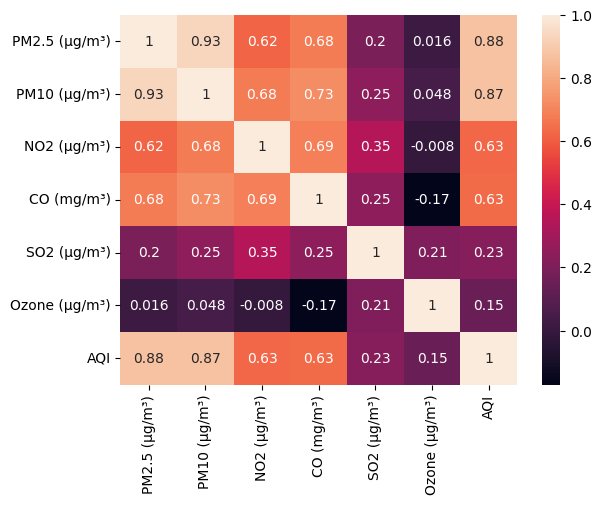

In [78]:
corr = clean_test_df.corr()
sns.heatmap(corr, annot=True)

<Axes: >

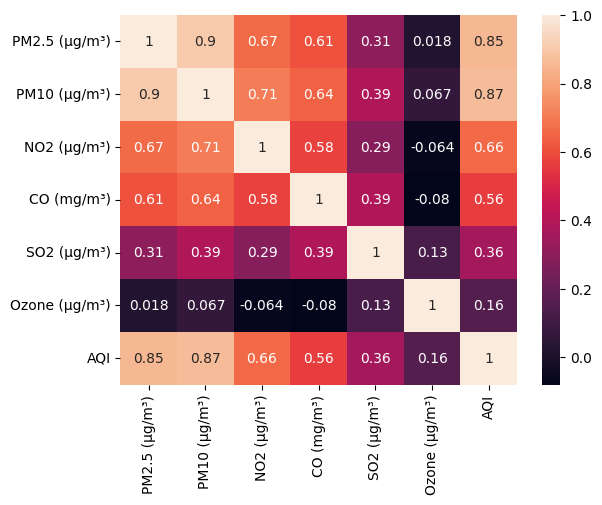

In [79]:
corr = clean_df.corr()
sns.heatmap(corr, annot=True)

In [80]:
clean_test_df

x_test_val=clean_test_df[['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'CO (mg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)']]
y_test_val=clean_test_df['AQI']

## -- x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x, y, test_size=0.2)

Training and validation of below models:
- Linear
- Lasso
- Decision Tree
- Random forest with GSCV
- Random forest with RSCV

In [81]:
x=clean_df[['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'CO (mg/m³)', 'SO2 (µg/m³)', 'Ozone (µg/m³)']]
y=clean_df['AQI']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

linear_regr_model = LinearRegression()
linear_regr_model.fit(x_train, y_train)
linear_regr_model_val_y_val = linear_regr_model.predict(x_test)

lasso_regr_model = Lasso()
lasso_regr_model.fit(x_train, y_train)
lasso_regr_model_val_y_val = lasso_regr_model.predict(x_test)

ridge_regr_model = Ridge()
ridge_regr_model.fit(x_train, y_train)
ridge_regr_model_val_y_val= ridge_regr_model.predict(x_test)

dt_regr_model = DecisionTreeRegressor()
dt_regr_model.fit(x_train, y_train)
dt_regr_model_val_y_val = dt_regr_model.predict(x_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create a Random Forest Regressor
rf_gscv = RandomForestRegressor(random_state=0)
rf_rscv = RandomForestRegressor(random_state=0)

# Define the parameter grid to search over
param_grid = {'max_depth': range(1, 5), 'n_estimators': range(1, 5)}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(rf_gscv, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the data
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print("GSCV Best Hyperparameters:", best_params)
print("GSCV Best Mean Score:", best_score)

rf_gscv.fit(x_train, y_train)
rf_gscv_val_y_val = rf_gscv.predict(x_test)

# Create a GridSearchCV object with 5-fold cross-validation
rand_search = RandomizedSearchCV(rf_rscv, param_grid, cv=5)

# Fit the GridSearchCV object to the data
rand_search.fit(x_train, y_train)

best_params = rand_search.best_params_
best_score = rand_search.best_score_

# Print the results
print("RSCV Best Hyperparameters:", best_params)
print("RSCV Best Mean Score:", best_score)

rf_rscv.fit(x_train, y_train)
rf_rscv_val_y_val = rf_rscv.predict(x_test)

GSCV Best Hyperparameters: {'max_depth': 4, 'n_estimators': 4}
GSCV Best Mean Score: 0.8077811263467278
RSCV Best Hyperparameters: {'n_estimators': 4, 'max_depth': 4}
RSCV Best Mean Score: 0.8077811263467278


Scoring accuracy for above trained models

In [82]:
linear_regr_train_acc = linear_regr_model.score(x_train,y_train)
lasso_regr_train_acc = lasso_regr_model.score(x_train,y_train)
ridge_regr_train_acc = ridge_regr_model.score(x_train,y_train)
dt_regr_train_acc = dt_regr_model.score(x_train,y_train)
rf_gscv_train_acc = rf_gscv.score(x_train,y_train)
rf_rscv_train_acc = rf_rscv.score(x_train,y_train)

print("\n--------------------------------------------------------")
print("Model\t\t\t RootMeanSquareError \t\t Accuracy of the model")
print("\n--------------------------------------------------------")
print("""Linear Regression \t\t {:.4f} \t \t\t {:.4f}""".format(  linear_regr_model.score(x_train,y_train), linear_regr_train_acc))
print("""Lasso Regression \t\t {:.4f} \t \t\t {:.4f}""".format(  lasso_regr_model.score(x_train,y_train), lasso_regr_train_acc))
print("""Ridge Regression \t\t {:.4f} \t \t\t {:.4f}""".format(  ridge_regr_model.score(x_train,y_train), ridge_regr_train_acc))
print("""Decision Tree Regressor\t\t {:.4f} \t \t\t {:.4f}""".format(  dt_regr_model.score(x_train,y_train), dt_regr_train_acc))
print("""Random Forest RegrGSCV\t\t {:.4f} \t \t\t {:.4f}""".format(  rf_gscv.score(x_train,y_train), rf_gscv_train_acc))
print("""Random Forest RegrRSCV\t\t {:.4f} \t \t\t {:.4f}""".format(  rf_rscv.score(x_train,y_train), rf_rscv_train_acc))



--------------------------------------------------------
Model			 RootMeanSquareError 		 Accuracy of the model

--------------------------------------------------------
Linear Regression 		 0.7983 	 		 0.7983
Lasso Regression 		 0.7982 	 		 0.7982
Ridge Regression 		 0.7983 	 		 0.7983
Decision Tree Regressor		 1.0000 	 		 1.0000
Random Forest RegrGSCV		 0.9814 	 		 0.9814
Random Forest RegrRSCV		 0.9814 	 		 0.9814


Test accuracy for above trained models

In [83]:

linear_regr_test_y_val = linear_regr_model.predict(x_test_val)

lasso_regr_test_y_val = lasso_regr_model.predict(x_test_val)

ridge_regr_test_y_val= ridge_regr_model.predict(x_test_val)

dt_regr_test_y_val = dt_regr_model.predict(x_test_val)

rf_gscv_test_y_val = rf_gscv.predict(x_test_val)

rf_rscv_test_y_val = rf_rscv.predict(x_test_val)

linear_regr_val_acc = linear_regr_model.score(x_test,y_test)
lasso_regr_val_acc = lasso_regr_model.score(x_test,y_test)
ridge_regr_val_acc = ridge_regr_model.score(x_test,y_test)
dt_regr_val_acc = dt_regr_model.score(x_test,y_test)
rf_gscv_val_acc = rf_gscv.score(x_test,y_test)
rf_rscv_val_acc = rf_rscv.score(x_test,y_test)

linear_regr_test_acc = linear_regr_model.score(x_test_val,y_test_val)
lasso_regr_test_acc = lasso_regr_model.score(x_test_val,y_test_val)
ridge_regr_test_acc = ridge_regr_model.score(x_test_val,y_test_val)
dt_regr_test_acc = dt_regr_model.score(x_test_val,y_test_val)
rf_gscv_test_acc = rf_gscv.score(x_test_val,y_test_val)
rf_rscv_test_acc = rf_rscv.score(x_test_val,y_test_val)


In [84]:
print("---------------------------------------------------------------------------------------------------------------")
print("Model\t\t\t\t Training acc. \t\t Validate acc.  \t\t Test acc.")
print("---------------------------------------------------------------------------------------------------------------")
print("""Linear Regression \t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(  linear_regr_train_acc, linear_regr_val_acc, linear_regr_test_acc))
print("""Lasso Regression \t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(  lasso_regr_train_acc, lasso_regr_val_acc, lasso_regr_test_acc))
print("""Ridge Regression \t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(  ridge_regr_train_acc, ridge_regr_val_acc, ridge_regr_test_acc))
print("""Decision Tree Regressor\t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(  dt_regr_train_acc, dt_regr_val_acc, dt_regr_test_acc))
print("""Random Forest RegrGSCV\t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(  rf_gscv_train_acc, rf_gscv_val_acc, rf_gscv_test_acc))
print("""Random Forest RegrRSCV\t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(  rf_rscv_train_acc, rf_rscv_val_acc, rf_rscv_test_acc))

---------------------------------------------------------------------------------------------------------------
Model				 Training acc. 		 Validate acc.  		 Test acc.
---------------------------------------------------------------------------------------------------------------
Linear Regression 		 0.7983 		 0.7942 			 0.8053
Lasso Regression 		 0.7982 		 0.7942 			 0.8059
Ridge Regression 		 0.7983 		 0.7942 			 0.8053
Decision Tree Regressor		 1.0000 		 0.7295 			 0.6724
Random Forest RegrGSCV		 0.9814 		 0.8659 			 0.8316
Random Forest RegrRSCV		 0.9814 		 0.8659 			 0.8316


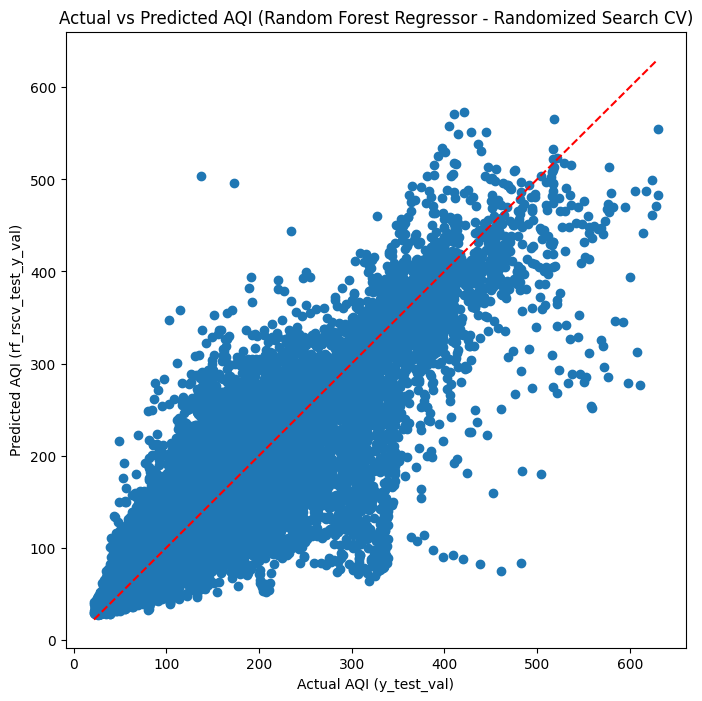

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_test_val, rf_rscv_test_y_val)
plt.xlabel("Actual AQI (y_test_val)")
plt.ylabel("Predicted AQI (rf_rscv_test_y_val)")
plt.title("Actual vs Predicted AQI (Random Forest Regressor - Randomized Search CV)")
plt.plot([min(y_test_val), max(y_test_val)], [min(y_test_val), max(y_test_val)], color='red', linestyle='--')
plt.show()

Training and validation of below models:
- CatBoost
- XGBoost


In [86]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

cat_model = CatBoostRegressor(silent=True)
cat_model.fit(x_train, y_train)
pred_cat = cat_model.predict(x_test)

print("Model\t\t\t RootMeanSquareError \t\t Accuracy of the model")
print("""CatBoost Regressor\t\t {:.4f} \t \t\t {:.4f}""".format(np.sqrt(mean_squared_error(y_test, pred_cat)), cat_model.score(x_train, y_train)))

Model			 RootMeanSquareError 		 Accuracy of the model
CatBoost Regressor		 32.3416 	 		 0.8793


Scoring training, validation and test accuracy for CatBoost model

In [87]:
cat_model_train_acc = cat_model.score(x_train,y_train)

cat_model_test_y_val = cat_model.predict(x_test_val)

cat_model_val_acc = cat_model.score(x_test,y_test)

cat_model_test_acc = cat_model.score(x_test_val,y_test_val)

In [88]:
print("----------------------------------------------------------------------------------------------")
print("Model\t\t\t Training acc. \t\t Validate acc.  \t\t Test acc.")
print("----------------------------------------------------------------------------------------------")
print("""CatBoost \t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(cat_model_train_acc, cat_model_val_acc, cat_model_test_acc))

----------------------------------------------------------------------------------------------
Model			 Training acc. 		 Validate acc.  		 Test acc.
----------------------------------------------------------------------------------------------
CatBoost 		 0.8793 		 0.8621 			 0.8368


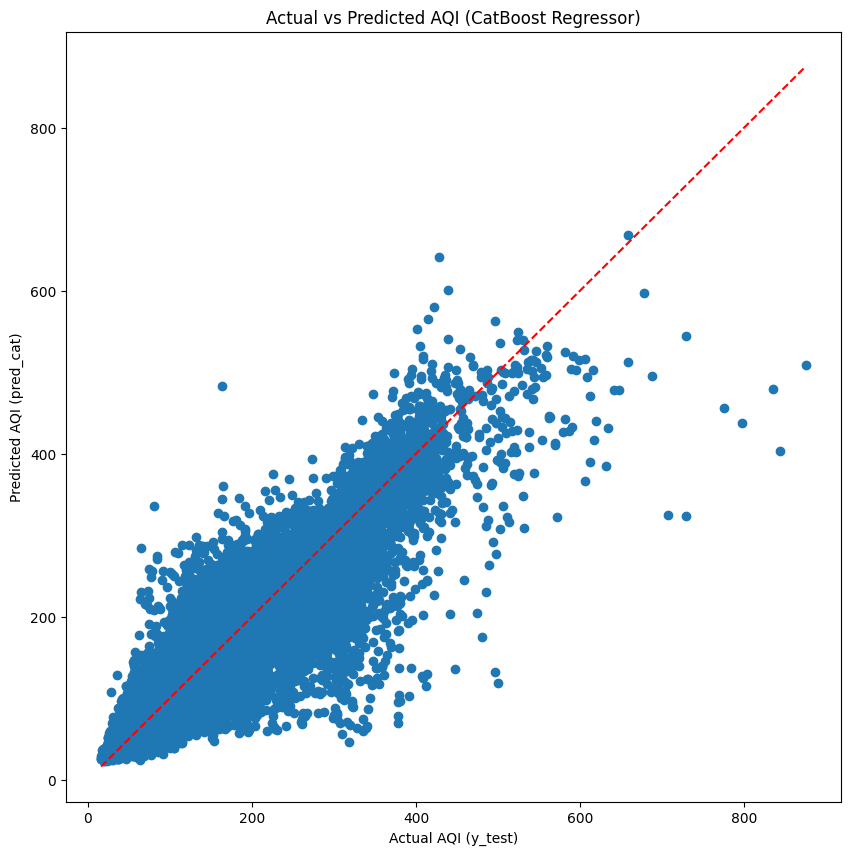

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(y_test, pred_cat)
plt.xlabel("Actual AQI (y_test)")
plt.ylabel("Predicted AQI (pred_cat)")
plt.title("Actual vs Predicted AQI (CatBoost Regressor)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

In [90]:
import warnings
from sklearn.metrics import mean_squared_error, r2_score

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

xg_model = XGBRegressor(eval_metric='rmse', use_label_encoder=False)

# Define the parameter distribution to sample from
param_dist = {
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, num=10),
    'n_estimators': np.arange(100, 500, 50)
}

# Create a RandomizedSearchCV object with 5-fold cross-validation
rand_search = RandomizedSearchCV(estimator=xg_model, param_distributions=param_dist,
                                 n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                 random_state=42, verbose=0)

# Fit the RandomizedSearchCV object to the training data
rand_search.fit(x_train, y_train)

# Get the best parameters and the corresponding mean score
best_params = rand_search.best_params_
best_score = -rand_search.best_score_

# Print the results
print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)

# Fit the best model on the full training set and make predictions
best_model = rand_search.best_estimator_
predictions = best_model.predict(x_test)

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Test Set RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

Best Hyperparameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.07444444444444444}
Best Mean Squared Error: 1008.1386141443096
Test Set RMSE: 31.946053185355208
R² Score: 0.8654400363334213


Scoring training, validation and test accuracy for XGBoost model

In [91]:
xgboost_model_train_acc = best_model.score(x_train,y_train)

xgboost_model_test_y_val = best_model.predict(x_test_val)

xgboost_model_val_acc = best_model.score(x_test,y_test)

xgboost_model_test_acc = best_model.score(x_test_val,y_test_val)

In [92]:
print("----------------------------------------------------------------------------------------------")
print("Model\t\t\t Training acc. \t\t Validate acc.  \t\t Test acc.")
print("----------------------------------------------------------------------------------------------")
print("""XGBOOST \t\t {:.4f} \t\t {:.4f} \t\t\t {:.4f}""".format(xgboost_model_train_acc, xgboost_model_val_acc, xgboost_model_test_acc))

----------------------------------------------------------------------------------------------
Model			 Training acc. 		 Validate acc.  		 Test acc.
----------------------------------------------------------------------------------------------
XGBOOST 		 0.9301 		 0.8654 			 0.8299


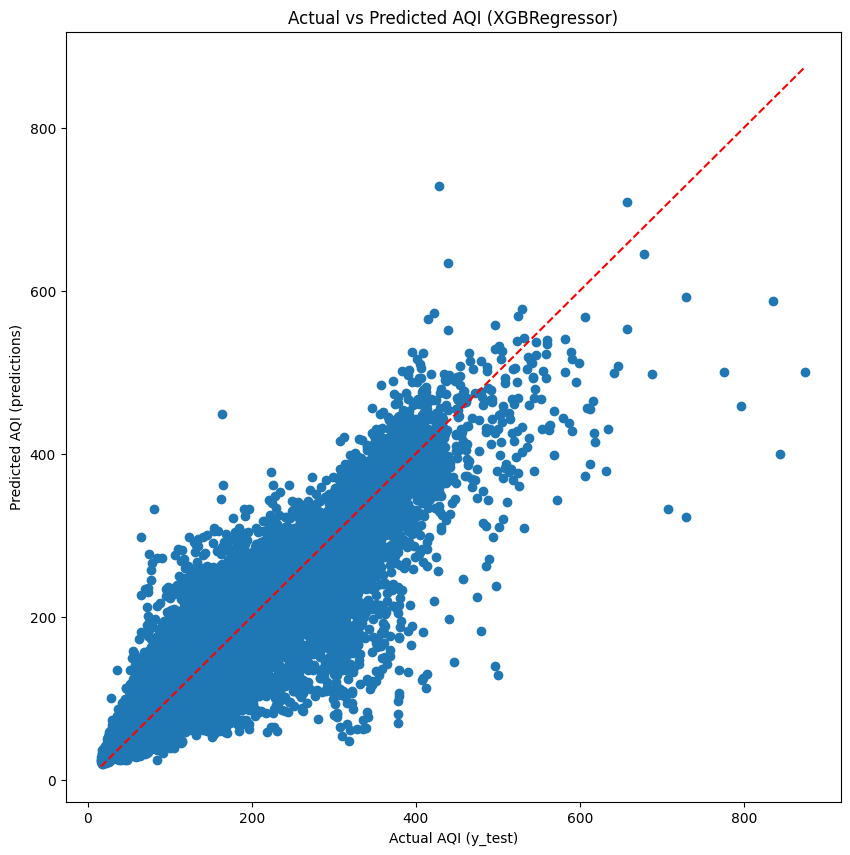

In [93]:
import matplotlib.pyplot as plt

# Assuming y_test and rf_rscv_val_y_val are defined from the previous code
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions)
plt.xlabel("Actual AQI (y_test)")
plt.ylabel("Predicted AQI (predictions)")
plt.title("Actual vs Predicted AQI (XGBRegressor)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Add a diagonal line for reference
plt.show()

-------------------------------------------------------------------------
-------------------------------------------------------------------------
**Comparison of train_acc, val_acc and test acc for each model**
-------------------------------------------------------------------------
-------------------------------------------------------------------------




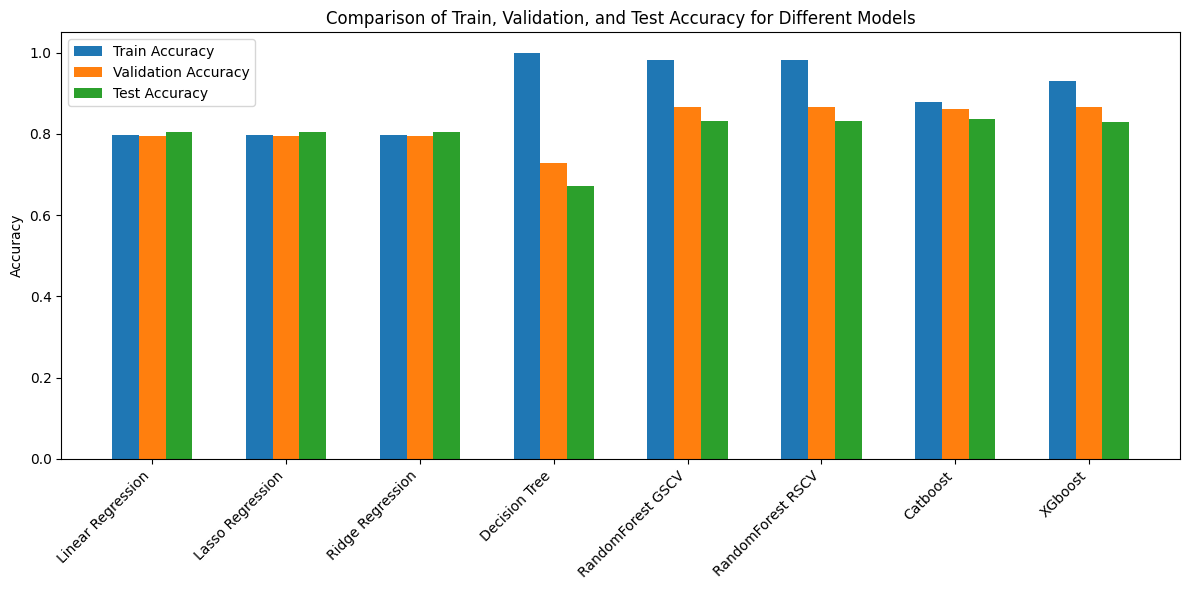

In [94]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Decision Tree', 'RandomForest GSCV', 'RandomForest RSCV','Catboost','XGboost']
train_acc = [linear_regr_train_acc, lasso_regr_train_acc, ridge_regr_train_acc, dt_regr_train_acc, rf_gscv_train_acc, rf_rscv_train_acc, cat_model_train_acc, xgboost_model_train_acc ]
val_acc = [linear_regr_val_acc, lasso_regr_val_acc, ridge_regr_val_acc, dt_regr_val_acc, rf_gscv_val_acc, rf_rscv_val_acc, cat_model_val_acc, xgboost_model_val_acc]
test_acc = [linear_regr_test_acc, lasso_regr_test_acc, ridge_regr_test_acc, dt_regr_test_acc, rf_gscv_test_acc, rf_rscv_test_acc, cat_model_test_acc, xgboost_model_test_acc]


X_axis = np.arange(len(models))

plt.figure(figsize=(12, 6))
plt.bar(X_axis - 0.2, train_acc, 0.2, label='Train Accuracy')
plt.bar(X_axis, val_acc, 0.2, label='Validation Accuracy')
plt.bar(X_axis + 0.2, test_acc, 0.2, label='Test Accuracy')


plt.xticks(X_axis, models, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Comparison of Train, Validation, and Test Accuracy for Different Models")
plt.legend()
plt.tight_layout()
plt.show()

----------------------------------------------------------------------------
----------------------------------------------------------------------------
**Plotting the predicted and actual values of the unseen data/test set (year 2023) for each model**
----------------------------------------------------------------------------
----------------------------------------------------------------------------

<Figure size 1500x1000 with 0 Axes>

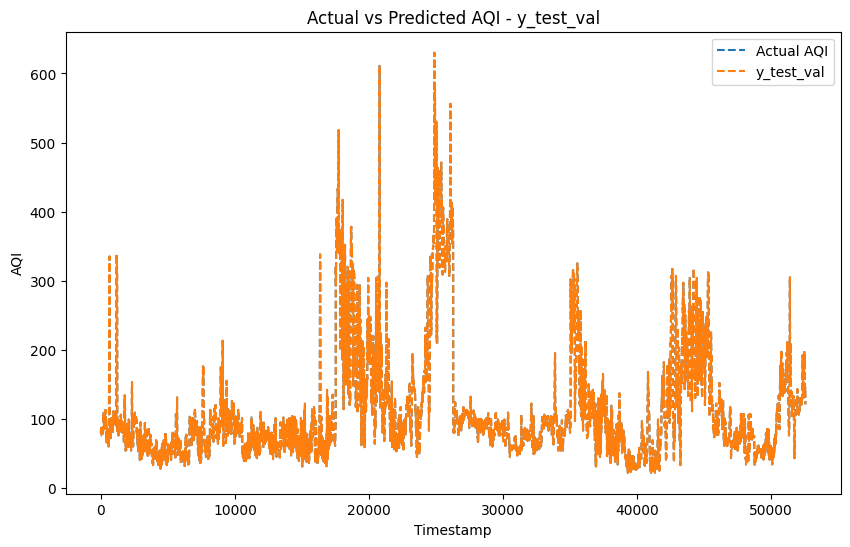

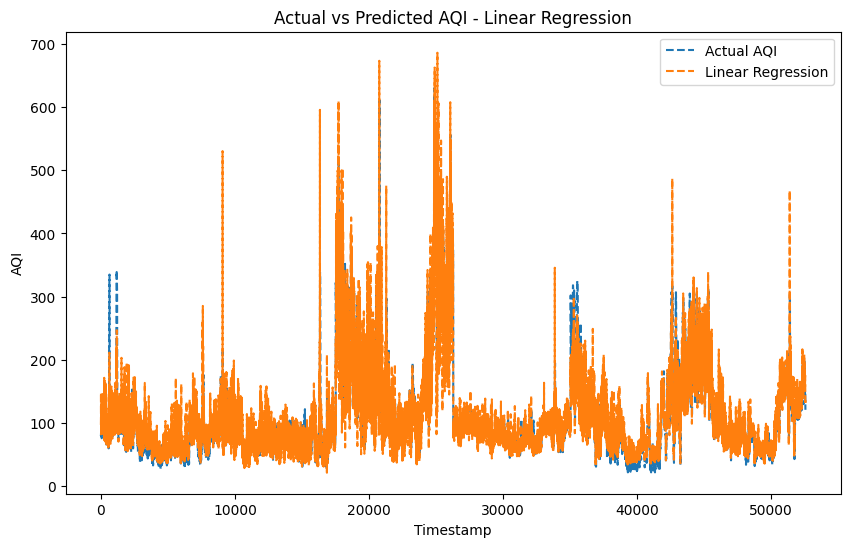

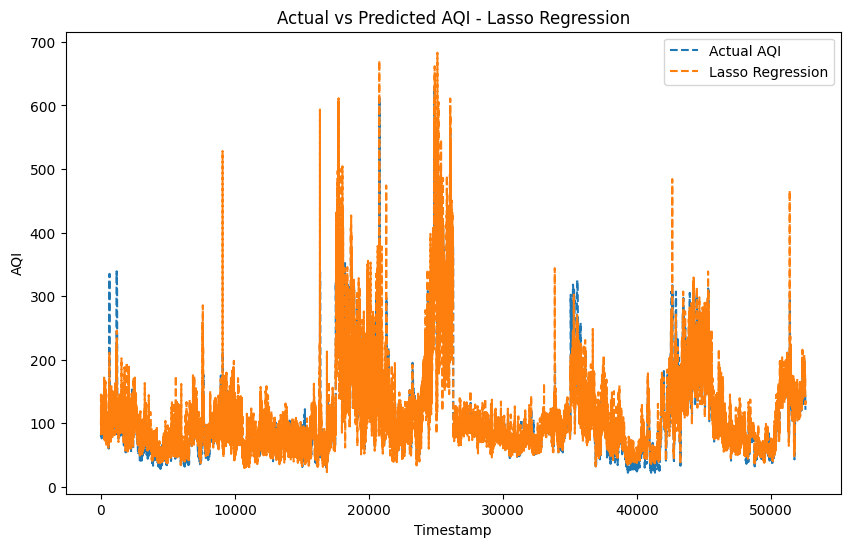

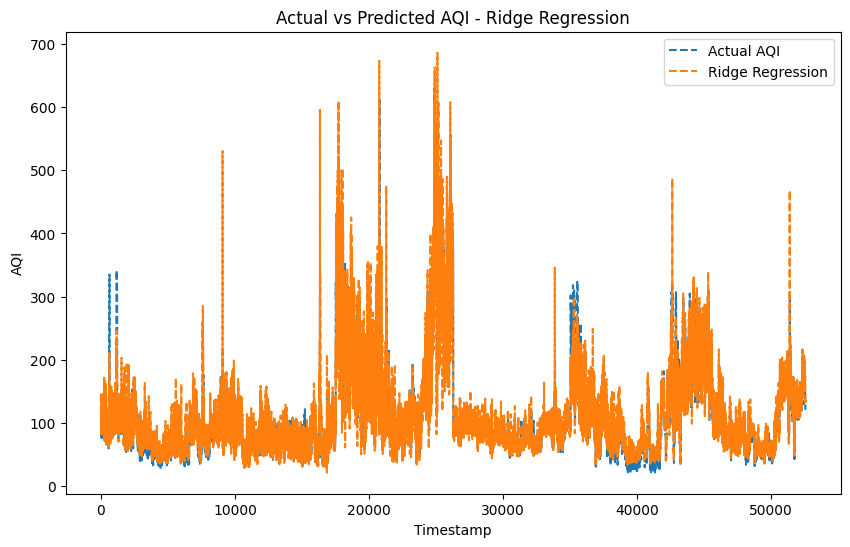

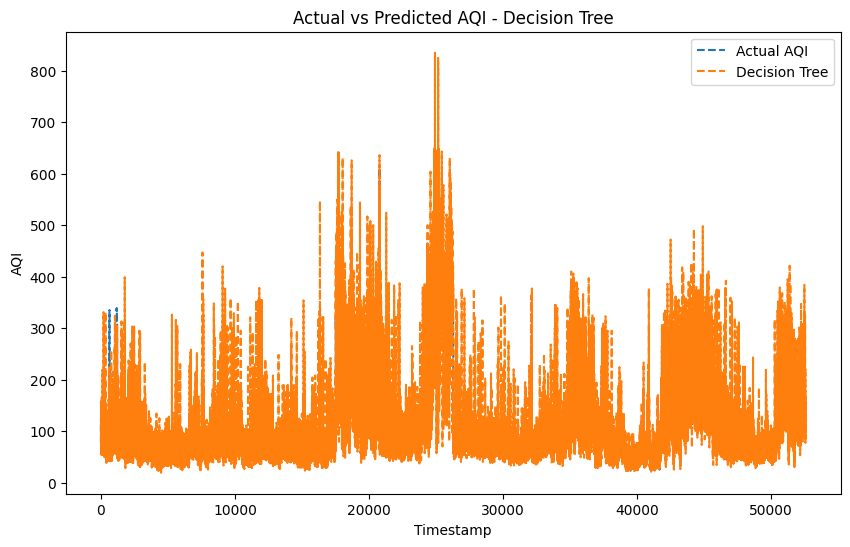

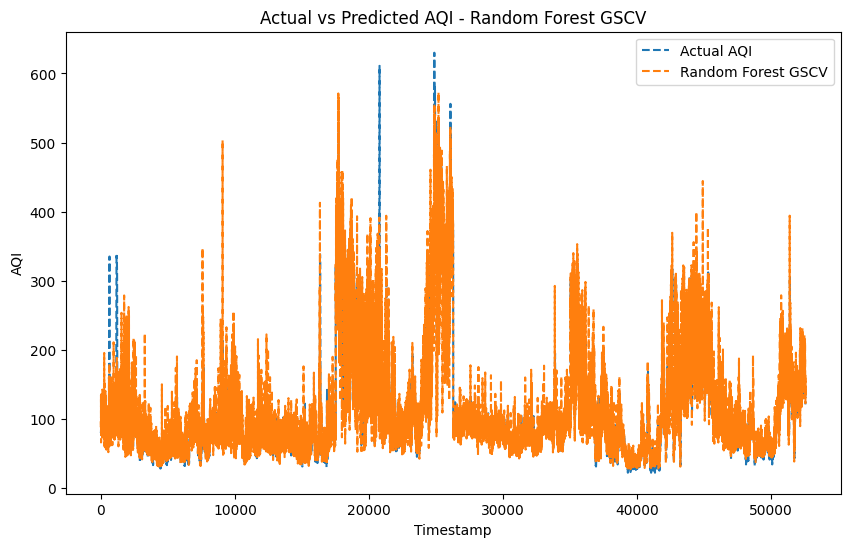

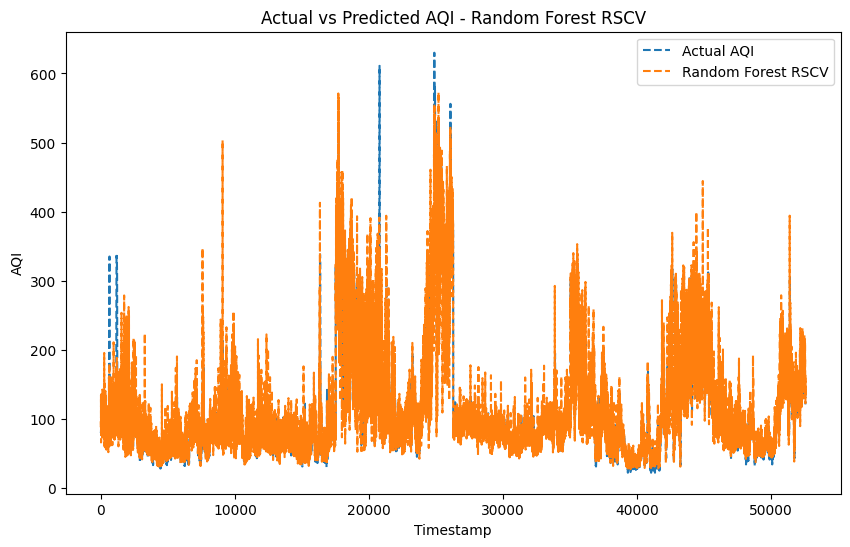

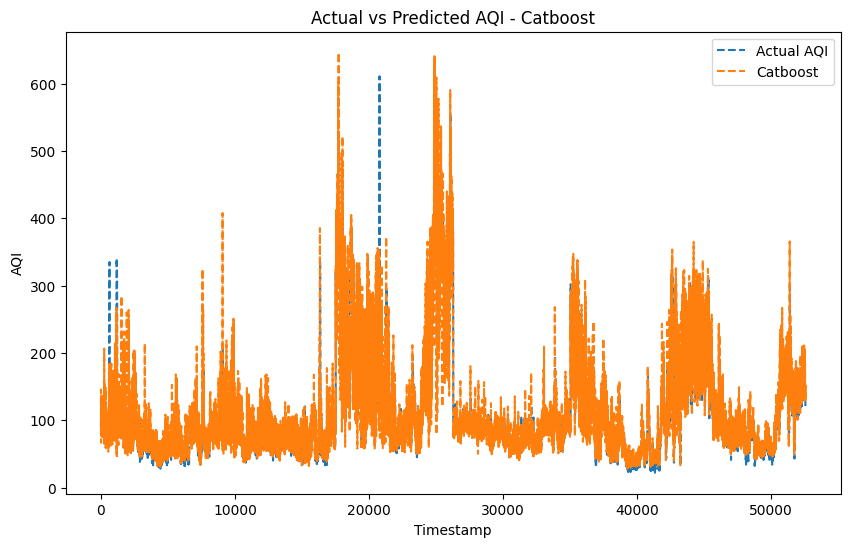

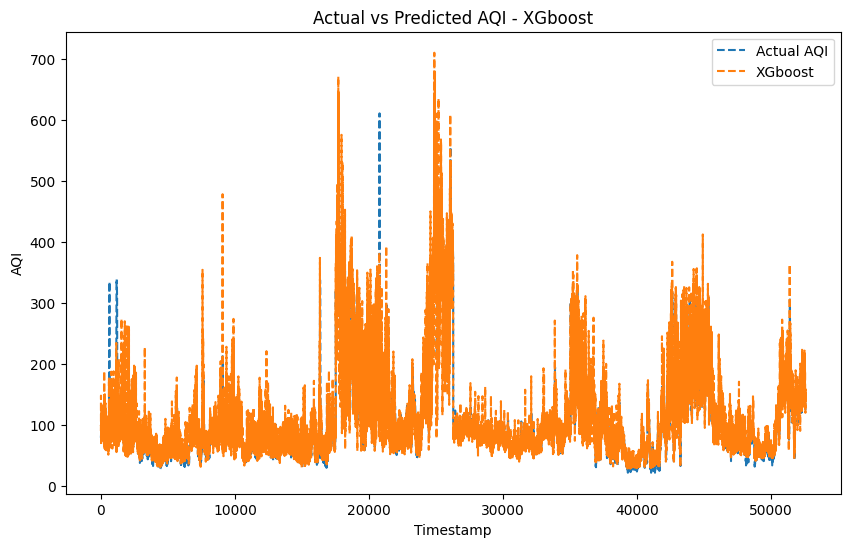

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'y_test_val': y_test_val,
    'Linear Regression': linear_regr_test_y_val,
    'Lasso Regression': lasso_regr_test_y_val,
    'Ridge Regression': ridge_regr_test_y_val,
    'Decision Tree': dt_regr_test_y_val,
    'Random Forest GSCV': rf_gscv_test_y_val,
    'Random Forest RSCV': rf_rscv_test_y_val,
    'Catboost' : cat_model_test_y_val,
    'XGboost' : xgboost_model_test_y_val
})

plot_data = plot_data.reset_index()


# Plot each model's predictions against actual values
plt.figure(figsize=(15, 10))
for model_name in plot_data.columns[1:]:
    plt.figure(figsize=(10,6))
    sns.lineplot(x='index', y='y_test_val', data=plot_data, label='Actual AQI', linestyle='--')
    sns.lineplot(x='index', y=model_name, data=plot_data, label=model_name, linestyle='--')
    plt.xlabel("Timestamp")
    plt.ylabel("AQI")
    plt.title(f"Actual vs Predicted AQI - {model_name}")
    plt.legend()
    plt.show()